In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import os
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import matplotlib
matplotlib.rcParams['font.family'] = 'Helvetica'

In [3]:
df_structures = pd.read_excel('count_fcc_fractions_byPalette.xlsx')
df_properties = pd.read_excel(
    'v6_Fe_Cr_Ni_Co_V_SSS_FCC_byCompo_wt_pct_ML_fcc_edit.xlsx')

fig_name = 'v6_Fe_Cr_Ni_Co_V_SSS_FCC_byCompo_wt_pct_ML_fcc_edit'

df_structures_Gmin_sort = df_structures.sort_values(
    by='Gmin_FCC_fraction', ascending=False)
df_structures_Gmineq_sort = df_structures.sort_values(
    by='Gmin_eq_FCC_fraction', ascending=False)

top = 10

display(df_structures_Gmin_sort.head(2))
display(df_structures_Gmineq_sort.head(2))

display(df_properties.head(2))

,ABCDE,Gmin_FCC_fraction,eq_FCC_fraction,Gmin_eq_FCC_fraction,Unnamed: 4
62,Ni-Cr-Co-V-Fe,73.913043,49.275362,47.826087,x
97,Fe-V-Co-Cr-Ni,71.014493,36.231884,36.231884,NaN


,ABCDE,Gmin_FCC_fraction,eq_FCC_fraction,Gmin_eq_FCC_fraction,Unnamed: 4
111,Fe-Ni-Co-Cr-V,59.420290,50.724638,50.724638,NaN
110,Fe-Ni-Co-V-Cr,57.971014,55.072464,50.724638,NaN


,Unnamed: 0.1,Unnamed: 0,Fe,Cr,Ni,Co,V,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,...,sigma_SSS_FCC,compo_A_B_C_D_E,H1_new_pred_KFold_mean,H1_new_pred_KFold_std,C2_new_pred_KFold_mean,C2_new_pred_KFold_std,H1_new_pred_KFold_mean_FCC,H1_new_pred_KFold_std_FCC,C2_new_pred_KFold_mean_FCC,C2_new_pred_KFold_std_FCC
0,0,0,34.167395,2.891940,5.441344,13.111107,44.388214,63.740744,0.329844,0.092273,...,NaN,V-Co-Ni-Cr-Fe,501.462250,121.009743,299.628906,225.678894,NaN,NaN,NaN,NaN
1,1,1,40.204113,4.798947,5.417690,11.966268,37.612981,66.837689,0.322980,0.091240,...,NaN,V-Co-Ni-Cr-Fe,492.357391,119.546692,312.933289,225.030975,NaN,NaN,NaN,NaN


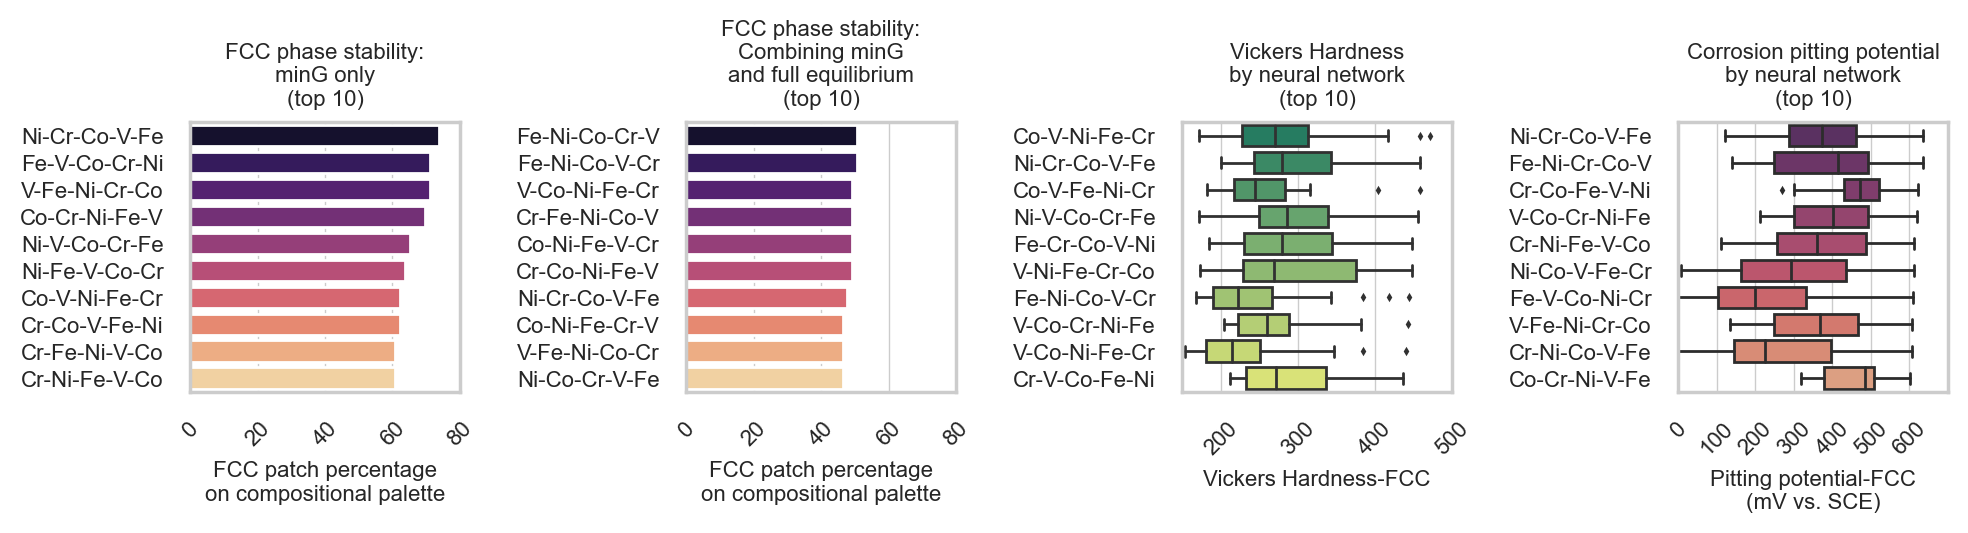

In [6]:
sns.set_theme(style="whitegrid", rc={"axes.grid": True, "grid.linewidth": 0.5})
fig, axs = plt.subplots(ncols=4, figsize=(10, 4), dpi=200)
font_size = 8

#
sns.barplot(y='ABCDE', x='Gmin_FCC_fraction', data=df_structures_Gmin_sort.head(
    top), linewidth=1, ax=axs[0], palette="magma")
axs[0].set_title(f"FCC phase stability:\nminG only\n(top {top})",
                 fontsize=font_size)
axs[0].set_xlabel('FCC patch percentage\non compositional palette',
                  fontsize=font_size)
axs[0].set_ylabel('')
axs[0].set_xlim([0, 80])
axs[0].set_xticks(range(0, 81, 20))  # Fixed the range here
axs[0].tick_params(axis='x', rotation=45)
axs[0].tick_params(axis='both', labelsize=font_size)
axs[0].set_box_aspect(top/10)

#
sns.barplot(y='ABCDE', x='Gmin_eq_FCC_fraction', data=df_structures_Gmineq_sort.head(
    top), linewidth=1, ax=axs[1], palette="magma")
axs[1].set_title(f"FCC phase stability:\nCombining minG\nand full equilibrium\n(top {top})",
                 fontsize=font_size)
axs[1].set_xlabel('FCC patch percentage\non compositional palette',
                  fontsize=font_size)
axs[1].set_ylabel('')
axs[1].set_xlim([0, 80])
axs[1].set_xticks(range(0, 81, 20))  # Fixed the range here
axs[1].tick_params(axis='x', rotation=45)
axs[1].tick_params(axis='both', labelsize=font_size)
axs[1].set_box_aspect(top/10)

#
H1_max_values = df_properties.groupby('compo_A_B_C_D_E')[
    'H1_new_pred_KFold_mean_FCC'].max()
H1_sorted_groups = H1_max_values.sort_values(ascending=False).head(top).index
sns.boxplot(x="H1_new_pred_KFold_mean_FCC", y="compo_A_B_C_D_E", data=df_properties,
            linewidth=1, fliersize=1, palette="summer", order=H1_sorted_groups, ax=axs[2])
axs[2].set_title(
    f'Vickers Hardness\nby neural network\n(top {top})', fontsize=font_size)
axs[2].set_xlabel('Vickers Hardness-FCC', fontsize=font_size)
axs[2].set_ylabel(None)
# axs[2].set_yticklabels([])
axs[2].set_xticks(range(0, 501, 100))
axs[2].set_xlim([150, 500])
axs[2].tick_params(axis='x', rotation=45)
axs[2].tick_params(axis='both', labelsize=font_size)
axs[2].set_box_aspect(top/10)

#
C2_max_values = df_properties.groupby('compo_A_B_C_D_E')[
    'C2_new_pred_KFold_mean_FCC'].max()
C2_sorted_groups = C2_max_values.sort_values(ascending=False).head(top).index
sns.boxplot(x="C2_new_pred_KFold_mean_FCC", y="compo_A_B_C_D_E", data=df_properties,
            linewidth=1, fliersize=1, palette="flare_r", order=C2_sorted_groups, ax=axs[3])
axs[3].set_title(
    f'Corrosion pitting potential\nby neural network\n(top {top})', fontsize=font_size)
axs[3].set_xlabel('Pitting potential-FCC\n(mV vs. SCE)',
                  fontsize=font_size)
axs[3].set_ylabel(None)
axs[3].set_xticks(range(0, 700, 100))
axs[3].set_xlim([0, 700])
axs[3].tick_params(axis='x', rotation=45)
axs[3].tick_params(axis='both', labelsize=font_size)
axs[3].set_box_aspect(top/10)

plt.tight_layout()
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()